## Dice fairness estimator for d20 dice

In this project, I estimate the likelihood that a 20-sided dice is fair. Fortunately, I had a couple of test dice: one relatively fair, and one with visible structural flaws that cause some sides to occur less often. These dice provided the test sets. 

There are two key outputs: an interactive visualization showing a dice's hot and cold spots, and a plot of whether a given distribution is likely to have occurred randomly. 

Tools: Monte Carlo methods, 3D vector math, sphere fitting

I'm using Monte Carlo data simulation as the basis for the statistics, since I want to compare against a perfectly random distribution. If the specific likelihood of a one-in-a-billion event mattered, this would be a bad solution, but I'm interested in common events, so this works great. 

In [1]:
#Calculate best-approximation of "center" of dice. Sum up number of 
#appearances for each face, treat as length of vector aiming toward
#that face, and sum the vectors

#1. Calculate the angle to each face, relative to top peak of '1':
#    a. Calculate spherical coordinates of each vertex
#    b. Calculate vector to center of each face (sum vertex vectors)
#    c. Assign numbers appropriately
#(Averaging angles means using circular statistics, found in scipy)


#Calculating spherical coordinates of each vertex:

#From Wikipedia "Regular Icosahedron":
#https://en.wikipedia.org/wiki/Regular_icosahedron#Spherical_coordinates
#    The locations of the vertices of a regular icosahedron can be described 
#    using spherical coordinates, for instance as latitude and longitude. If 
#    two vertices are taken to be at the north and south poles (latitude ±90°),
#    then the other ten vertices are at latitude ±arctan(1/2) ≈ ±26.57°. These 
#    ten vertices are at evenly spaced longitudes (36° apart), alternating 
#    between north and south latitudes. 
#(Implemented below)


#Calculating vector for the center of each face:

#Select the three vertices (numbered as described below) that are associated
#with each face. Sum the cartesian vectors for each vertex, then normalize to
#vector amplitude of one. 

In [2]:
#Import libraries/functions:

import numpy as np
import pandas as pd
from scipy.stats import circmean 
from sklearn.linear_model import LinearRegression
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.transforms import Affine2D

#OR, instead of struggling to make matplotlib do what it's not built to do,
#I could just use plotly, which is built to handle 3D. 
import plotly.graph_objects as go


In [3]:
%config Completer.use_jedi = False

In [4]:
#Initialize an rng instance:
rng = np.random.default_rng()

In [5]:
#Convenience function: Convert from polar coordinates to cartesian coords
def polar_to_cartesian(polarmat, thetatype='to_north'):
    #polarmat format: If matrix, is rows of 3-var polar coordinates
    #                 If list, is list of lists of 3-var polar coords
    #                 (Probably works for list of 3-var vectors, too)
    
    #If it's not an array already, make it an array
    if isinstance(polarmat, list):
        polarmat = np.array(polarmat)
        
    if len(polarmat.shape)<=1:
        one_row = True
    else:
        one_row = False
    
    #If the data doesn't include radius information, assume it's one
    if one_row:    
        if polarmat.shape[0]==2: 
            polarmat = np.insert(polarmat, 0, 1)
    else:
        if polarmat.shape[1]==2:
            polarmat = np.insert(polarmat, 0, 1, axis=1)
    
    #Check the theta convention: 'to_north' or 'to_xy'
    if thetatype=='to_north':
        #No transformation needed:
        polarmat = polarmat
    elif thetatype=='to_xy':
        #Convert theta values from "angle from x/y plane" to "angle from
        #north pole" to fit slightly-more-standard spherical coord system
        polarmat[:,1] = -1 * (polarmat[:,1] - pi/2)
        
    cartmat = np.zeros(polarmat.shape)
    
    if one_row:
        cartmat[0] = polarmat[0] * np.sin(polarmat[1]) * np.cos(polarmat[2])
        cartmat[1] = polarmat[0] * np.sin(polarmat[1]) * np.sin(polarmat[2])
        cartmat[2] = polarmat[0] * np.cos(polarmat[1])
    else:
        cartmat[:,0] = polarmat[:,0] * np.sin(polarmat[:,1]) * np.cos(polarmat[:,2])
        cartmat[:,1] = polarmat[:,0] * np.sin(polarmat[:,1]) * np.sin(polarmat[:,2])
        cartmat[:,2] = polarmat[:,0] * np.cos(polarmat[:,1])
    
    return cartmat


#Convenience function: Convert from cartesian to polar coords
def cartesian_to_polar(cartmat, thetatype='to_north'):
    #polarmat format: If matrix, is rows of 3-var polar coordinates
    #                 If list, is list of lists of 3-var polar coords
    #                 (Probably works with list of 3-var vectors, too)
    
    #If it's not an array already, make it an array
    if isinstance(cartmat, list):
        cartmat = np.array(cartmat)
        
    polarmat = np.zeros(cartmat.shape)
    
    if len(cartmat.shape)<=1:
        one_row = True
    else:
        one_row = False
    
    #Radius:
    if one_row:
        polarmat[0] = np.sqrt(np.sum(np.square(cartmat)))
        #Theta:
        polarmat[1] = np.arccos(cartmat[2]/polarmat[0])
        #Phi:
        polarmat[2] = np.arctan(cartmat[1]/cartmat[0])
    else:
        polarmat[:,0] = np.sqrt(np.sum(np.square(cartmat), axis=1))
        #Theta:
        polarmat[:,1] = np.arccos(cartmat[:,2]/polarmat[:,0])
        #Phi:
        polarmat[:,2] = np.arctan(cartmat[:,1]/cartmat[:,0])
    
    #Check the theta convention: 'to_north' or 'to_xy'
    if thetatype=='to_north':
        #No transformation needed:
        polarmat = polarmat
    elif thetatype=='to_xy':
        #Convert theta values from "angle from x/y plane" to "angle from
        #north pole" to fit slightly-more-standard spherical coord system
        polarmat[:,1] = -1 * (polarmat[:,1] - pi/2)
    
    return polarmat

In [6]:
#Vertex numbering (this does not make sense unless following 
#along on a dice): Start at top vertex (v1), proceed to the lower
#right vertex of '1' (v2), proceed counterclockwise (looking down
#at v1) through the other nine non-pole vertices (v3-v11). That 
#ends on the 'top' vertex of the upside-down 13. v11 is taken as
#the "zero" point for all longitude values. Then proceed to the
#bottom vertex (v12).

at_1 = np.arctan(1/2)
pi = np.pi

#v1-v12, in order, make up 'va' (vertex angles):
va = [[ pi/2, 0],
      [ 1*at_1, 1*36*pi/180],
      [-1*at_1, 2*36*pi/180],
      [ 1*at_1, 3*36*pi/180],
      [-1*at_1, 4*36*pi/180],
      [ 1*at_1, 5*36*pi/180],
      [-1*at_1, 6*36*pi/180],
      [ 1*at_1, 7*36*pi/180],
      [-1*at_1, 8*36*pi/180],
      [ 1*at_1, 9*36*pi/180],
      [-1*at_1, 10*36*pi/180],
      [-pi/2, 0]
     ]

#Convert vertices to cartesian for use later:
va_cart = polar_to_cartesian(va, thetatype='to_xy')

#Collect vertices associated with each face (f1-f20)
#NOTE: THESE FACES ARE FOR THE STANDARD D&D DICE. OTHER
#DICE SYSTEMS SOMETIMES USE DIFFERENT NUMBER LOCATIONS.
fa_raw = [[va[0], va[1], va[9]],   #1
          [va[6], va[8], va[11]],  #2
          [va[0], va[3], va[5]],   #3
          [va[2], va[10], va[11]], #4
          [va[8], va[9], va[10]],  #5
          [va[2], va[3], va[4]],   #6
          [va[0], va[7], va[9]],   #7
          [va[4], va[5], va[6]],   #8
          [va[1], va[2], va[3]],   #9
          [va[5], va[6], va[7]],   #10
          [va[1], va[2], va[10]],  #11
          [va[6], va[7], va[8]],   #12
          [va[1], va[9], va[10]],  #13
          [va[2], va[4], va[11]],  #14
          [va[7], va[8], va[9]],   #15
          [va[3], va[4], va[5]],   #16
          [va[0], va[5], va[7]],   #17
          [va[8], va[10], va[11]], #18
          [va[0], va[1], va[3]],   #19
          [va[4], va[6], va[11]]   #20
         ]
#Convert to 20x3x2 array (face, vect, theta/phi)
fa_raw = np.array(fa_raw)

#Build the vector version:
fv_pre = np.zeros([20,3,3])
for n in range(3):
    fv_pre[:,n,0:3] = polar_to_cartesian(fa_raw[:,n,:], thetatype='to_xy')

In [7]:
fv = np.sum(fv_pre, axis=1)
vect_len = np.sqrt(np.sum(np.square(fv), axis=1)) 
#All vectors should have identical length at this point, but
#left "vect_len" a vector for easy inspection. 
fv = np.divide(fv, vect_len[0])

# #Double-check vector lengths (should be 1):
# np.sqrt(np.sum(np.square(fv), axis=1))

In [8]:
#Input a set of dice rolls. Get the frequency of each number, 
#then just multiply the frequency vector by the array vector
#and sum it together to get the average vector that the dice
#favors! Now that we have the 'fv' vector, it's super simple.

#IMPORT DATA

#Use an example set:
test_dice = pd.read_excel('Dice_test.xlsx')
test_dice_2 = pd.read_excel('Dice_test_2.xlsx', names=['Red','Aquamarine','Black','Purple'])
test_dice_2_notes = test_dice_2.iloc[-1,:]
test_dice_2 = test_dice_2[:-1].astype(int)
# test_dice = test_dice[['Orange:','Blue:']]

#Example test analysis:
test_set = test_dice.iloc[:, 1]
test_hist, test_bins = np.histogram(test_set, bins=np.arange(0.5,21.5))

#This line is the key: Multiply the face vectors matrix by the
#frequency vector. Gives you the next XYZ vector, then scale it
#to the total number of rolls. 
outvec = np.matmul(test_hist.T, fv)/len(test_set)

num_str = [str(tempnum) for tempnum in range(1,21)]
ov_mag = np.sqrt(np.sum(np.square(outvec)))
ov_big = outvec/ov_mag

print('In this set, the dice tended toward: \n' + str(outvec))
if ov_mag < 0.05:
    print('This is a relatively small bias, magnitude {0:.3f}'.format(ov_mag))
else:
    print('This is a relatively large bias, magnitude {0:.3f}'.format(ov_mag))
text_outind = np.argmax(np.matmul(fv, outvec))
print('\nThe bias vector points toward dice face ' + num_str[text_outind])


In this set, the dice tended toward: 
[ 0.00687338 -0.01076649 -0.00847589]
This is a relatively small bias, magnitude 0.015

The bias vector points toward dice face 18


In [9]:
#ASSUMPTION: Any weight bias will result in an offset of likelihood
#between the different numbers, and that offset approximates a sphere. 

#GOAL: Fit a sphere to the frequency vectors. 
#The idea here is to see how closely a sphere fits the data. If the
#fit is poor, it's likely that any bias you're seeing is due to random
#chance, or possibly small variations in the surface of the dice. Any
#ellipsoid would probably also work, it's not clear to me that a sphere
#is the optimal shape, but should approximate it reasonably well. Any 
#systematic error that DOES have a good sphere fit is likely to reflect
#a weight imbalance.

#Alternative: Could also achieve a similar end goal by testing a simple
#correlation of how often the values for adjacent sides are similar. 

#Alternative 2: Could calculate "slope" from the direction pole to the
#counter pole in roughly 6 directions, test slope fit. 

#If I wanted to get VERY fancy, I could simulate the effects of change
#in the center of mass using a physics engine, but that's overkill.

#Sphere:
#Basic equation: (x+x0)^2 + (y+y0)^2 + (z+z0)^2 = R^2
#Fitting variables: x0, y0, z0, R
#Cost: (x+x0)^2 + (y+y0)^2 + (z+z0)^2 - R^2 (minimize radial distance)
#I'd rather not do the partial derivatives and gradient myself, so I'm 
#cribbing the math from a MATLAB implementation of sphere fitting:

#https://www.mathworks.com/matlabcentral/fileexchange/34129-sphere-fit-least-squared

#which uses a normal equation solution. 

#Matlab code:
# A=[mean(X(:,1).*(X(:,1)-mean(X(:,1)))), ...
#     2*mean(X(:,1).*(X(:,2)-mean(X(:,2)))), ...
#     2*mean(X(:,1).*(X(:,3)-mean(X(:,3)))); ...
#     0, ...
#     mean(X(:,2).*(X(:,2)-mean(X(:,2)))), ...
#     2*mean(X(:,2).*(X(:,3)-mean(X(:,3)))); ...
#     0, ...
#     0, ...
#     mean(X(:,3).*(X(:,3)-mean(X(:,3))))];
# A=A+A.';
# B=[mean((X(:,1).^2+X(:,2).^2+X(:,3).^2).*(X(:,1)-mean(X(:,1))));...
#     mean((X(:,1).^2+X(:,2).^2+X(:,3).^2).*(X(:,2)-mean(X(:,2))));...
#     mean((X(:,1).^2+X(:,2).^2+X(:,3).^2).*(X(:,3)-mean(X(:,3))))];
# Center=(A\B).';
# Radius=sqrt(mean(sum([X(:,1)-Center(1),X(:,2)-Center(2),X(:,3)-Center(3)].^2,2)));

#Translated to Python:
def fit_sphere(X):
    #Fits a sphere to a given set of Cartesian points. May fail
    #at small numbers of points. If you're working with a small
    #number of integer data points, like rolls, you may want to
    #pre-process your data, since a pile of zeros does not work
    #very well. I would recommend adding 0.05 times the vector,
    #for example. 
    
    #Might only need slight reworking if I wanted to try a sphere
    #with fixed radius? Unclear. 
    
    A = [[np.mean(X[:,0]*(X[:,0]-np.mean(X[:,0]))),
          2*np.mean(X[:,0]*(X[:,1]-np.mean(X[:,1]))),
          2*np.mean(X[:,0]*(X[:,2]-np.mean(X[:,2])))],
         [0,
          np.mean(X[:,1]*(X[:,1]-np.mean(X[:,1]))),
          2*np.mean(X[:,1]*(X[:,2]-np.mean(X[:,2])))],
         [0,
          0,
          np.mean(X[:,2]*(X[:,2]-np.mean(X[:,2])))]]
    A = np.array(A)
    A = A + A.T
    B = [np.mean((X[:,0]*X[:,0] + X[:,1]*X[:,1] + X[:,2]*X[:,2]) * (X[:,0]-np.mean(X[:,0]))),
         np.mean((X[:,0]*X[:,0] + X[:,1]*X[:,1] + X[:,2]*X[:,2]) * (X[:,1]-np.mean(X[:,1]))),
         np.mean((X[:,0]*X[:,0] + X[:,1]*X[:,1] + X[:,2]*X[:,2]) * (X[:,2]-np.mean(X[:,2])))]
    B = np.array(B).T
    Center = np.linalg.lstsq(A,B, rcond=None)[0]
    Radius = np.sqrt(np.mean(np.sum(
        np.square(np.array([X[:,0]-Center[0],X[:,1]-Center[1],X[:,2]-Center[2]]).T), axis=1
    )));
    
    return Center, Radius

def sphere_error(X, Center, Radius):
    #To calculate error, we want the distance between the
    #sphere and the face endpoint along the face vector.
    
    #Calculate location on the sphere where the ratio between
    #x, y, and z is the same as it is in the target vector:
    
    #Get the fixed ratio values between the elements, so we 
    #can express y & z as multiples of x:
    yrat = X[:,1]/X[:,0] #ratio of y to x, elementwise
    zrat = X[:,2]/X[:,0] #ratio of z to x, elementwise
    #Plug into sphere equation, simplify to ax^2+bx+c=0:
    a = 1 + np.square(yrat) + np.square(zrat)
    b = 2*Center[0] + 2*yrat*Center[1] + 2*zrat*Center[2]
    c = np.square(np.array([Center[0], Center[1], Center[2], Radius]))
    c = c[0]+c[1]+c[2]-c[3]
    #Ye olde Pythagorean Theorem:
    try:
        xint1 = (-b + np.sqrt(np.square(b) - 4*a*c))/(2*a)
        xint2 = (-b - np.sqrt(np.square(b) - 4*a*c))/(2*a)
    except:
        xint1 = (-b + np.sqrt(np.square(b) - 4*a*c))/(2*a)
        xint2 = (-b - np.sqrt(np.square(b) - 4*a*c))/(2*a)
        print(X, np.square(b) - 4*a*c)
    
    #Xintercept is about the X array, not the x direction.
    Xintercept1 = np.array([xint1, yrat*xint1, zrat*xint1]).T
    Xintercept2 = np.array([xint2, yrat*xint2, zrat*xint2]).T

    #Could do the math with least-squares distances, but this
    #way is pretty fast. Only selecting between two points for
    #each of 20 base coordinates.
    #Error between each (two-element) sphere solution and X:
    Xerror_pre = np.array([np.sum(X - Xintercept1, axis=1), np.sum(X - Xintercept2, axis=1)])
    #Pick the smaller-amplitude of the two errors, then add 
    #the absolute values up for the whole dataset. 
    Xerror = np.sum(np.min(np.abs(Xerror_pre.T), axis=1))
    
    #Useful to have the raw individual-face errors:
    tempinds = np.argmin(np.abs(Xerror_pre.T), axis=1)
    Xerror_face = [Xerror_pre.T[n,tempinds[n]] for n in range(X.shape[0])]
    
    return Xerror, Xerror_face


#Both functions are pretty efficient, run time a little under 1ms. 

In [10]:
#Can throw some warnings. Would be nice to clean them up,
#but it's fine.

#Pick a random subset of rolls from test_dice:
test_set = test_dice.iloc[:,0]
rng.shuffle(test_set.values)
test_set = test_set[0:200]

test_hist, test_bins = np.histogram(test_set, bins=np.arange(0.5,21.5))

#Going to bias the histogram a tiny bit to avoid division
#errors when using small sets of rolls. Errs VERY slightly
#toward assuming the data is evenly distributed. 
test_hist = test_hist + 0.0001

#Element-wise multiply the face vectors with how
#many times each face was rolled
X = (fv.T*test_hist.T).T

dice_sphere = fit_sphere(X)

print(dice_sphere)
Center = dice_sphere[0]
Radius = dice_sphere[1]

Xerror = sphere_error(X, Center, Radius)

print('Total sphere error across all faces: {0:.2f} / {1} rolls'.format(Xerror[0], sum(test_hist[0:20])))

(array([ 1.43914433, -0.11800323,  3.29539461]), 11.058568370081863)
Total sphere error across all faces: 63.65 / 200.00200000000004 rolls


In [11]:
#Re-initialize rng for shuffling, etc.
rng = np.random.default_rng()

Looks good!

And stats-wise... looking at Dice 0, when "biasvec" input is set to true, you can see the bias vector. It's the little green thing, and it doesn't seem to be a helpful indicator of which faces have more rolls. It's not wrong, but it's not helpful. Offsetting a sphere has the same problem. Either is *accurate*, but not very *useful*, because the dice is biased by face geometry, not weight. There is still enough bias toward one side that they do tell you something, like pointing away from the cold spot on Dice 0, but the displayed dice does better.

I am reasonably sure that dice 0 (the Orange dice) is somewhat biased, given the large difference between the sides, and the fact that there is a clear order to it. However, that order is not what I was expecting. It looks like there's a cold spot, but instead of the corresponding higher areas being on the opposite side from the cold spot (like you might expect if the dice was heavier on one side), the hottest spots are right around the edge. This suggests that rather than having a weight imbalance, it has an edge imbalance. Perhaps the edges around 7 (opposite 14), may be less pronounced. This would lead to the dice tending to continue rolling, rather than stopping with that face down. 


Next steps: 

1) Use a sphere to display the likelihood instead of a dice? The smoothness might make the face bias and hot/cold spots easier to see, and it would be a good chance to learn how to map and smooth data onto a surface.  
2) Histogram sorted by frequency, compare to randomly-generated sets of rolls. This will be a good way to distinguish visually between random error and systematic bias. Working now, see below.

In [12]:
#DISPLAY THE DICE, TRIMMED:

#Does a fresh roll likelihood check using the number of rolls
#found in the input, rather than using precomputed rolls. Avoids
#the need to calculate histograms or number of expected rolls 
#based on a combination of two bracketing roll sets.

def display_dice_v2(dice_set, use_offset=True, use_offsetvec=False, cmap='rdbu_r', biasvec=False):
    '''Outputs the relative weight of each face for a given set of rolls'''

    
    # #Shuffle the dice (very handy for subsampling):
    # rng.shuffle(dice_set.values)
    
    #Histogram the dice:
    dice_hist, dice_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
    
    #Make a list of the face options:
    num_str = [str(tempnum) for tempnum in range(1,21)]

    #Vectors for showing the data:

    #Put in the vector of points in x,y,z; then put in the
    #point indices (i.e. point 0, point 1, etc.) that make
    #up the individual triangles. This is basically how I 
    #built the 'fa' face angles vector in the first place,
    #so I just copied the 'va' indices from that.

    #Draw the shape (color for frequency of face selection):
    tri_i = [0,6,0,2,8,2,0,4,1,5,1,6,1,2,7,3,0,8,0,4]
    tri_j = [1,8,3,10,9,3,7,5,2,6,2,7,9,4,8,4,5,10,1,6]
    tri_k = [9,11,5,11,10,4,9,6,3,7,10,8,10,11,9,5,7,11,3,11]

    tri_int = dice_hist
    
    #va_cart = polar_to_cartesian(va, thetatype='to_xy')
    tri_x = va_cart[:,0]
    tri_y = va_cart[:,1]
    tri_z = va_cart[:,2]
    
    #Build the dice faces:
    fig = go.Figure(data=[
        go.Mesh3d(
            x=tri_x, 
            y=tri_y, 
            z=tri_z,
            colorscale=cmap,
            cmax= 2*len(dice_set)/20, cmin=0,
            #Max at double standard likelihood, 
            #min at zero for equal color weights
            i=tri_i,
            j=tri_j,
            k=tri_k,
            intensity = tri_int,
            intensitymode = 'cell',
            lighting=dict(ambient=1)
        )])
    
    
    #Set offset properties for all above-face markers:
    scale_facevec = 20/len(dice_set)
    scale_foffset = 0.7558/.9551 #distance to center of face / radius, as fraction of edge length
    
    #Add the expected-value markers:
    
    #Expected value endpoint locations:
    temp_x3 = fv[:,0]*(scale_foffset+(len(dice_set)/20)*scale_facevec)
    temp_y3 = fv[:,1]*(scale_foffset+(len(dice_set)/20)*scale_facevec)
    temp_z3 = fv[:,2]*(scale_foffset+(len(dice_set)/20)*scale_facevec)
    
    #Expected value vectors:
    temp_x = zip(fv[:,0]*(scale_foffset+len(dice_set)/20*scale_facevec), fv[:,0]*scale_foffset, [None] * 20)
    temp_x4 = []
    for temptup in temp_x:
        temp_x4 = temp_x4 + list(temptup)
    temp_x4 = np.array(temp_x4)
    temp_y = zip(fv[:,1]*(scale_foffset+len(dice_set)/20*scale_facevec), fv[:,1]*scale_foffset, [None] * 20)
    temp_y4 = []
    for temptup in temp_y:
        temp_y4 = temp_y4 + list(temptup)
    temp_y4 = np.array(temp_y4)
    temp_z = zip(fv[:,2]*(scale_foffset+len(dice_set)/20*scale_facevec), fv[:,2]*scale_foffset, [None] * 20)
    temp_z4 = []
    for temptup in temp_z:
        temp_z4 = temp_z4 + list(temptup)
    temp_z4 = np.array(temp_z4)
    
    #Plot expected value vectors if requested:
    if use_offset:
        fig.add_trace(go.Scatter3d(x=temp_x3, y=temp_y3, z=temp_z3,
                                   mode='markers',
                                   marker={'color':'darkgray',
                                           'symbol':'circle',
                                           'size':6}))
        #Vectors don't work very well right now, end up showing on top.
        #May have to redo, only drawing the vector from bar endpoint to
        #expected value, and only where actual is less, so no overlap.
        if use_offsetvec:
            fig.add_trace(go.Scatter3d(x=temp_x4, y=temp_y4, z=temp_z4,
                                       mode='lines',
                                       line={'width':4,
                                             'color':'darkgray',
                                             'dash':'dot'}))

    #Draw a path that goes along every edge:
    all_edge_vertpath = [0,1,3,0,5,3,2,4,3,5,4,6,5,7,6,8,7,0,9,7,8,9,1,10,8,11,10,2,11,4,6,11,10,9,1,2]
    tri_x_alledges = tri_x[all_edge_vertpath]
    tri_y_alledges = tri_y[all_edge_vertpath]
    tri_z_alledges = tri_z[all_edge_vertpath]

    fig.add_trace(go.Scatter3d(x=tri_x_alledges, 
                               y=tri_y_alledges, 
                               z=tri_z_alledges,
                               mode='lines',
                               name='vertices',
                               marker=dict(
                                   size=12,
                                   color=1,
                                   opacity=1
                               )
                              ))


    
    #Build a vector to show frequency for each face:
    
    for n in range(20):
        fig.add_trace(go.Scatter3d(x=[fv[n,0]*(scale_foffset+dice_hist[n]*scale_facevec), fv[n,0]*scale_foffset*0.92],
                                   y=[fv[n,1]*(scale_foffset+dice_hist[n]*scale_facevec), fv[n,1]*scale_foffset*0.92],
                                   z=[fv[n,2]*(scale_foffset+dice_hist[n]*scale_facevec), fv[n,2]*scale_foffset*0.92],
                                   mode='markers',
                                   #mode='lines+markers',
                                   #line={'width': 2,
                                   #     'color': 'black',
                                   #    },
                                   marker={'size': 4,
                                           'color': [dice_hist[n]*scale_facevec,dice_hist[n]*scale_facevec],
                                           'colorscale': cmap,
                                           'cmax': 2,
                                           'cmin': 0,
                                           #'line':{'color':'black', 'width':4}
                                          }
                                  ))
        fig.add_trace(go.Scatter3d(x=[fv[n,0]*(scale_foffset+dice_hist[n]*scale_facevec), fv[n,0]*scale_foffset*0.92],
                                   y=[fv[n,1]*(scale_foffset+dice_hist[n]*scale_facevec), fv[n,1]*scale_foffset*0.92],
                                   z=[fv[n,2]*(scale_foffset+dice_hist[n]*scale_facevec), fv[n,2]*scale_foffset*0.92],
                                   mode='lines+markers',
                                   line={'width': 16,
                                         'color': [dice_hist[n]*scale_facevec,dice_hist[n]*scale_facevec],
                                         'colorscale': cmap,
                                         'cmax': 2,
                                         'cmin': 0
                                        },
                                   marker={'size': 3,
                                           'color': [dice_hist[n]*scale_facevec,dice_hist[n]*scale_facevec],
                                           'colorscale': cmap,
                                           'cmax': 2,
                                           'cmin': 0
                                          }
                                  ))
    
    #Label the faces, on the end of each scale vec:
    labels_scalevec = 0.2 + scale_foffset+dice_hist*scale_facevec
    labelmin = 0.2 + scale_foffset+(len(dice_set)/20)*scale_facevec
    labels_scalevec[labels_scalevec < labelmin] = labelmin
    fig.add_trace(go.Scatter3d(x=fv[:,0]*labels_scalevec,
                               y=fv[:,1]*labels_scalevec,
                               z=fv[:,2]*labels_scalevec,
                               text=num_str,
                               textfont=dict(
                                   family="sans serif",
                                   size=20,
                                   color='darkblue'
                               ),
                               mode='text',
                               textposition="middle center"
                              ))
    
    #     #Label the faces (on the face):
    #     fig.add_trace(go.Scatter3d(x=fv[:,0]*1.1, y=fv[:,1]*1.1, z=fv[:,2]*1.1,
    #                                text=num_str,
    #                                textfont=dict(
    #                                    family="sans serif",
    #                                    size=20,
    #                                    color='darkblue'
    #                                ),
    #                                mode='text',
    #                                textposition="middle center"
    #                               ))

    fig.update_layout(showlegend=False)

    fig.show()
    

In [13]:
#For a random dice, calculate adjacency likelihood 
#(will be part of "display_dice_hist" when complete)

from sklearn.covariance import EllipticEnvelope

def calculate_adjacency(dice_set, debug=False):
    #Assuming DnD dice numbering. Could calculate
    #these relationships based on known positioning, 
    #but this is faster, and a good spot to mess 
    #with dictionaries.
    oneedge = {1:  [ 7,13,19],
               2:  [12,18,20],
               3:  [16,17,19],
               4:  [11,14,18],
               5:  [13,15,18],
               6:  [ 9,14,16],
               7:  [ 1,15,17],
               8:  [10,16,20],
               9:  [ 6,11,19],
               10: [ 8,12,17],
               11: [ 4, 9,13],
               12: [ 2,10,15],
               13: [ 1, 5,11],
               14: [ 4, 6,20],
               15: [ 5, 7,12],
               16: [ 3, 6, 8],
               17: [ 3, 7,10],
               18: [ 2, 4, 5],
               19: [ 1, 3, 9],
               20: [ 2, 8,14]
              }
    #Good spot for a graph object. These are derivative of oneedge.
    twoedge = {1:  [ 3, 5, 9,11,15,17],
               2:  [ 4, 5, 8,10,14,15],
               3:  [ 1, 6, 7, 8, 9,10],
               4:  [ 2, 5, 6, 9,13,20],
               5:  [ 1, 2, 4, 7,11,12],
               6:  [ 3, 4, 8,11,19,20],
               7:  [ 3, 5,10,12,13,19],
               8:  [ 2, 3, 6,12,14,17],
               9:  [ 1, 3, 4,13,14,16],
               10: [ 2, 3, 7,15,16,20],
               11: [ 1, 5, 6,14,18,19],
               12: [ 5, 7, 8,17,18,20],
               13: [ 4, 7, 9,15,18,19],
               14: [ 2, 8, 9,11,16,18],
               15: [ 1, 2,10,13,17,18],
               16: [ 9,10,14,17,19,20],
               17: [ 1, 8,12,15,16,19],
               18: [11,12,13,14,15,20],
               19: [ 6, 7,11,13,16,17],
               20: [ 4, 6,10,12,16,18]
              }
    
    tic = time.perf_counter()
    #Need to redo for each dice set fed in.
    dice_hist, dice_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
    toc1 = time.perf_counter()
    
    #Goal: Calculate how much adjacency predicts higher/lower values.

    face_err1 = {}
    face_err2 = {}
    face_err3 = {}
    face_expect = len(dice_set)/20
    for key in oneedge:
        #total RMSE for each face vs. 3 nearest or 6 next-nearest
        face_err1[key] = np.sqrt(sum([(dice_hist[key-1] - dice_hist[item-1])**2 for item in oneedge[key]]))
        face_err2[key] = np.sqrt(sum([(dice_hist[key-1] - dice_hist[item-1])**2 for item in twoedge[key]]))
        face_err3[key] = (dice_hist[key-1] - face_expect)**2
        
    toc2 = time.perf_counter()
    
    if debug == True:
        print(toc1-tic, toc2-toc1)
    return face_err1, face_err2, face_err3


def calculate_adjacency_mat(dice_set, debug=False):
    #Assuming DnD dice numbering. Could calculate
    #these relationships based on known positioning, 
    #but this is faster, and a good spot to mess 
    #with dictionaries.
    numrolls = len(dice_set)
    
    oneedge = {1:  [ 7,13,19],
               2:  [12,18,20],
               3:  [16,17,19],
               4:  [11,14,18],
               5:  [13,15,18],
               6:  [ 9,14,16],
               7:  [ 1,15,17],
               8:  [10,16,20],
               9:  [ 6,11,19],
               10: [ 8,12,17],
               11: [ 4, 9,13],
               12: [ 2,10,15],
               13: [ 1, 5,11],
               14: [ 4, 6,20],
               15: [ 5, 7,12],
               16: [ 3, 6, 8],
               17: [ 3, 7,10],
               18: [ 2, 4, 5],
               19: [ 1, 3, 9],
               20: [ 2, 8,14]
              }
    #Good spot for a graph object, in theory, since these
    #are derived from oneedge, but recalculating which faces
    #are two/three edges away every time would cost a bit, 
    #and this runs a lot.
    twoedge = {1:  [ 3, 5, 9,11,15,17],
               2:  [ 4, 5, 8,10,14,15],
               3:  [ 1, 6, 7, 8, 9,10],
               4:  [ 2, 5, 6, 9,13,20],
               5:  [ 1, 2, 4, 7,11,12],
               6:  [ 3, 4, 8,11,19,20],
               7:  [ 3, 5,10,12,13,19],
               8:  [ 2, 3, 6,12,14,17],
               9:  [ 1, 3, 4,13,14,16],
               10: [ 2, 3, 7,15,16,20],
               11: [ 1, 5, 6,14,18,19],
               12: [ 5, 7, 8,17,18,20],
               13: [ 4, 7, 9,15,18,19],
               14: [ 2, 8, 9,11,16,18],
               15: [ 1, 2,10,13,17,18],
               16: [ 9,10,14,17,19,20],
               17: [ 1, 8,12,15,16,19],
               18: [11,12,13,14,15,20],
               19: [ 6, 7,11,13,16,17],
               20: [ 4, 6,10,12,16,18]
              }
    
    tic = time.perf_counter()
    #Need to redo for each dice set fed in.
    dice_hist, dice_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
    toc1 = time.perf_counter()
    
    #Goal: Calculate how much adjacency predicts higher/lower values.

    face_err1 = np.zeros([20])
    face_err2 = np.zeros([20])
    face_err3 = np.zeros([20])
    face_expect = len(dice_set)/20 #expected num times for each face
    for key in oneedge:
        #total RMSE for each face vs. 3 nearest faces
        #(scaled by expected number of rolls, i.e. 2 is 2x the number you'd expect for 20 rolls)
        face_err1[key-1] = np.sqrt(sum([(dice_hist[key-1] - dice_hist[item-1])**2 / (numrolls/20) for item in oneedge[key]]))
        #vs. 6 further faces
        face_err2[key-1] = np.sqrt(sum([(dice_hist[key-1] - dice_hist[item-1])**2 / (numrolls/20) for item in twoedge[key]]))
        #error of each individual face versus mean (single value, RMSE unnecessary)
        face_err3[key-1] = abs(dice_hist[key-1] - face_expect) / (numrolls/20)
        
    toc2 = time.perf_counter()
    
    if debug == True:
        print('Hist: {:.6f}, err_calc: {.6f}, all {.6f}'.format(toc1-tic, toc2-toc1, toc2-tic))
    return face_err1, face_err2, face_err3

In [14]:
from matplotlib.lines import Line2D
from scipy.stats import chisquare

def plot_dice_stats_v2(dice_set, numsets=10000):

    #Generate a matched set of random rolls:
    rng = np.random.default_rng()
    numrolls = len(dice_set)
    test_hists = np.zeros([numsets, 20])
    test_sets = np.zeros([numsets, len(dice_set)])
    for n in range(numsets):
        test_set = rng.integers(size=[numrolls,1], high=21, low=1)
        test_sets[n,:] = test_set.squeeze()
        temphist, tempbins = np.histogram(test_set, bins=np.arange(0.5,21.5))
        test_hists[n,:] = temphist
    
    #Process the dice data:
    dice_hist, dice_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
    dice_hist_inds = np.argsort(dice_hist) #Get which faces appeared, in what order
    dice_hist = dice_hist[dice_hist_inds] #Get the (sorted) face frequencies
    
    #Set the max range of the histogram to 1/4 of total rolls:
    #(any dice worse than that is so biased you don't need stats)
    if numrolls < 100:
        histrange = int(numrolls * 0.5) #If there are very few rolls, stay wider
    else:
        histrange = int(numrolls * 0.25)
    
    #Sort the randomized data by face frequency:
    test_hists2 = np.sort(np.array(test_hists).squeeze(),axis=1)
    test_hist = []
    for n in range(20):
        temphist = np.histogram(test_hists2[:,n], bins=np.arange(-0.5,histrange+1.5))
        test_hist.append(temphist[0])
    test_hist = np.array(test_hist).squeeze().astype(float)
    #Reassign all zero values to NaN so they don't plot:
    test_hist_nans = np.copy(test_hist)
    test_hist_nans[test_hist_nans==0] = np.nan

    chisq, p = chisquare(dice_hist)

    plt.figure(figsize=[10,10])
    ax = plt.subplot(111)
    scaledhist1 = 0.5*test_hist_nans.T/(1.1*np.max(test_hist,axis=1)) + np.tile(np.arange(0.5,20.5),[histrange+1,1])
    scaledhist2 = -0.5*test_hist_nans.T/(1.1*np.max(test_hist,axis=1)) + np.tile(np.arange(0.5,20.5),[histrange+1,1])
    ax.set_ylim(-0.5,21)
    minx = test_hists.min()
    maxx = test_hists.max()
    ax.set_xlim([-0.25*maxx, maxx*1.05]) #scaled to min: min([minx*.6, minx-5])
    ax.plot([0,0],[-0.5,20.5], color='whitesmoke', linewidth=2) #Zero line
    ax.plot([numrolls/20, numrolls/20],[-0.5,21], color='whitesmoke', linewidth=5) #Expected value line
    ax.plot(scaledhist1,'gray')
    ax.plot(scaledhist2,'gray')
    ax.set_yticks(np.arange(20)+0.5)
    ax.set_yticklabels(['Least   \ncommon'] + ['']*18 + ['Most    \ncommon'])
    ax.set_ylabel('Dice face, ranked by how often it was rolled')
    ax.set_xlabel('How often each face appeared in {} randomly generated sets of {} rolls'.format(numsets, numrolls))
    #VERTICAL LINE:
    #ax.plot(np.array([test_hist_1, test_hist_1]), np.array([np.arange(0,20), np.arange(1,21)]), 'r')
    #SYMBOL:
    ax.plot(dice_hist, np.arange(0,20)+0.5, 'rd')
    
    #Plot 5th percentile/95th percentile:
    #SHOULD WEIGHT BETWEEN ADJACENT NUMBERS BY FRACTION
    base_num_05 = np.percentile(test_hists2, 5, axis=0)
    base_num_95 = np.percentile(test_hists2, 95, axis=0)
    #print(list(zip(base_num_05, base_num_95)))
    ax.plot([base_num_05, base_num_95],
            [np.arange(0,20)+0.50, np.arange(0,20)+0.50], 'b+')
    #ax.plot(, np.arange(0,20)+0.5, 'bx')
    
    temp_maxes = np.argmax(test_hist, axis=1)
    temp_means = np.matmul(test_hist, np.arange(histrange+1))/np.nansum(test_hist_nans, axis=1)
    plt.plot(np.array([temp_means, temp_means]), np.array([np.arange(0,20), np.arange(1,21)]), 'b')
    #Label by likelihood:
    ax.text(.015, .966, 'Face:',
            verticalalignment='center', transform=ax.transAxes)
    ax.text(.08, .966, 'You rolled the face at this rank\nmore than X% of random sets:', 
            verticalalignment='center', transform=ax.transAxes)
    n_likelihoods = []
    for n in range(20):
        offset_var = dice_hist[n] - temp_means[n]
        offset_var = -1*histrange*(int(offset_var<0) - 0.25)*0.04
        n_likelihood1 = np.sum(test_hist[n, :dice_hist[n]])/np.sum(test_hist[n,:])
        n_likelihood2 = np.sum(test_hist[n, :dice_hist[n]+1])/np.sum(test_hist[n,:])
        if np.abs(n_likelihood1 - 0.5) > np.abs(n_likelihood2 - 0.5):
            n_likelihood = n_likelihood2
        else:
            n_likelihood = n_likelihood1
        n_likelihoods.append(n_likelihood)
        hmin = 0.042
        hmax = 0.926
        ax.text(0.03, hmin + n*(hmax-hmin)/19, num_str[dice_hist_inds[n]], transform=ax.transAxes)
        ax.text(0.09, hmin + n*(hmax-hmin)/19, s='>{0:.2f}%'.format(n_likelihood*100), transform=ax.transAxes)


    custom_lines = [Line2D([0], [0], color='b', lw=2),
                    Line2D([0], [0], marker="+", color='b',
                          markerfacecolor='b', lw=0),
                    Line2D([0], [0], marker='d', color='w', 
                          markerfacecolor='r', lw=2),
                    Line2D([0], [0], color='gray', lw=2)
                   ]
    ax.legend(custom_lines, ['Typical number of\nrolls for this rank', 
                             'How often it rolled\nin 5%/95% of sets',
                             'Your dice', 
                             'Distribution of\nunbiased rolls', ], loc='lower right')    

    dice_likelihood = min([1 - max(n_likelihoods), min(n_likelihoods)])

    if p < 0.005:
        titlelikelihood = 'Very likely biased.'
    elif p < 0.05:
        titlelikelihood = 'Possibly biased.'
    elif p < 0.10:
        titlelikelihood = 'Reply hazy, try rolling more.'
    else:
        titlelikelihood = 'May be fine!'

    titletext = "Dice verdict: Chance of happening at random ~{:.2f}%. {}".format(p*100, titlelikelihood)

    plt.title(titletext)
    plt.show()

    return dice_hist, test_hist, test_sets, numsets

In [29]:
def get_adjacency_likelihood(dice_set, test_sets):
    
    face_err1_set = np.zeros([test_sets.shape[0], 20])
    face_err2_set = np.zeros([test_sets.shape[0], 20])
    face_err3_set = np.zeros([test_sets.shape[0], 20])
    for n in range(test_sets.shape[0]):
        face_err1_set[n,:], face_err2_set[n,:], face_err3_set[n,:] = calculate_adjacency_mat(test_sets[n,:])
    
    test_err1 = np.sqrt(np.sum(np.square(face_err1_set), axis=1))
    test_err2 = np.sqrt(np.sum(np.square(face_err2_set), axis=1))
    test_err3 = np.sqrt(np.sum(np.square(face_err3_set), axis=1))
    
    dice_err1_pre, dice_err2_pre, dice_err3_pre = calculate_adjacency_mat(dice_set)
    dice_err1 = np.sqrt(np.sum(np.square(dice_err1_pre)))
    dice_err2 = np.sqrt(np.sum(np.square(dice_err2_pre)))
    dice_err3 = np.sqrt(np.sum(np.square(dice_err3_pre)))
    
    #Generate values for the 2D histogram (skip 3)
    histbins = [np.linspace(min( [min(test_err1), dice_err1*0.9] )*0.9,
                            max( [max(test_err1), dice_err1*1.1] )*1.1,num=30),
                np.linspace(min( [min(test_err2), dice_err2*0.9] )*0.9,
                            max( [max(test_err2), dice_err2*1.1] )*1.1,num=30),
                #np.linspace(min( [min(test_err3), dice_err3*0.9] )*0.9,
                #            max( [max(test_err3), dice_err3*1.1] )*1.1,num=30),
               ]
    
    #Pretty standard anomaly detection method: Elliptic envelope fit
    EllEnv = EllipticEnvelope(random_state=0, support_fraction=0.99, contamination=0.01)
    EllEnv.fit(np.vstack([test_err1, test_err2, test_err3]).T)
    inside_set = EllEnv.predict(np.vstack([dice_err1, dice_err2, dice_err3]).T)
    if inside_set == 1:
        inside_text = 'Same set'
    else:
        inside_text = 'Different set'
    
    fig = plt.figure(figsize=[10,10])
    plt.hist2d(test_err1, test_err2, bins=histbins)
    plt.plot(dice_err1, dice_err2, 'rd', label='Your dice')
    plt.text(dice_err1, dice_err2*1.05, '3-error estimate: {}'.format(inside_text), 
             ha='center', va='bottom', backgroundcolor='gray')
    plt.title('Face adjacency: Total difference between each face and its nearby faces')
    plt.xlabel('Adjacency difference, vs. faces with a shared edge (3)')
    plt.ylabel('Adjacency difference, vs. faces with a shared corner (6)')
    plt.legend()
    
    #fig = plt.figure(figsize=[10,10])
    #out = plt.hist(test_err1, bins=histbins[0])
    #plt.plot(dice_err1, max(out[0])/2, 'rd', label='Your dice')
    #plt.text(dice_err1, 1.05*max(out[0])/2, 'Same set? {}'.format(inside_text), ha='center', va='bottom')
    #plt.title('Face adjacency: Total difference between each face and its nearby faces')
    #plt.legend()
    
    plt.show()
    return test_err1, test_err2, dice_err1, dice_err2

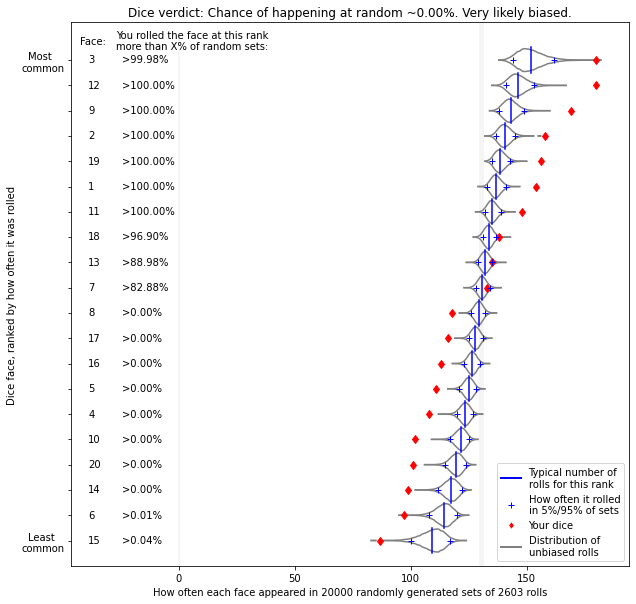

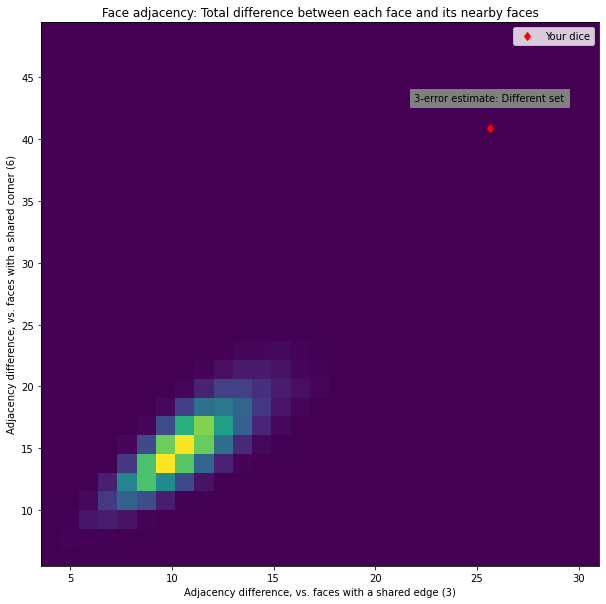

In [31]:
#CALL THE DISPLAY FUNCTIONS:

#Only rerun if you want to change the selection
nrolls = 500
%matplotlib inline

if True:
    #dice_set = rng.choice(test_dice.iloc[:,0], nrolls, shuffle=False)
    dice_set = test_dice.iloc[:,0]

display_dice_v2(dice_set)
dice_hist, test_hist, test_sets, numsets = plot_dice_stats_v2(dice_set, numsets=20000)
test_err1, test_err2, dice_err1, dice_err2 = get_adjacency_likelihood(dice_set, test_sets)

In [ ]:
#TESTING


face_err1_set = np.zeros([test_sets.shape[0], 20])
face_err2_set = np.zeros([test_sets.shape[0], 20])
face_err3_set = np.zeros([test_sets.shape[0], 20])
for n in range(test_sets.shape[0]):
    face_err1_set[n,:], face_err2_set[n,:], face_err3_set[n,:] = calculate_adjacency_mat(test_sets[n,:])

test_err1 = np.sqrt(np.sum(np.square(face_err1_set), axis=1))
test_err2 = np.sqrt(np.sum(np.square(face_err2_set), axis=1))
test_err3 = np.sqrt(np.sum(np.square(face_err3_set), axis=1))

test_errs = np.vstack([test_err1, test_err2, test_err3]).T


#Test set of "contamination" results:
dice_dims = []
for n in range(200):
    tempset = rng.choice(test_dice.iloc[:,0], nrolls, shuffle=False)
    dice_err1_pre, dice_err2_pre, dice_err3_pre = calculate_adjacency_mat(tempset)
    dice_dims.append([np.sqrt(np.sum(np.square(dice_err1_pre))),
                      np.sqrt(np.sum(np.square(dice_err2_pre))),
                      np.sqrt(np.sum(np.square(dice_err3_pre)))])
dice_dims = np.array(dice_dims)


#Test out an appropriately-fitted EllipticEnveloped and MinCovDet,
#assuming that our dice 0 should be excluded. 
EllEnv = EllipticEnvelope(support_fraction=0.98, contamination=0.02)
EllEnv.fit(test_errs)
dice_preds = EllEnv.predict(dice_dims)
test_preds = EllEnv.predict(test_errs)

In [ ]:
set1 = dice_preds == 1
set2 = dice_preds == -1

print('Non-separable:',sum(set1), ', separable:', sum(set2))

%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(test_errs[:500,0], test_errs[:500,1], test_errs[:500,2], 'r+')
ax.plot(dice_dims[set1,0], dice_dims[set1,1], dice_dims[set1,2], 'rx')
ax.plot(dice_dims[set2,0], dice_dims[set2,1], dice_dims[set2,2], 'bx')

In [ ]:
# 0.30463092423455634 1.58290871499275 1.3740451229854136

np.linspace(min( [.305, 1.374-2] )-1,
            max( [1.583, 1.374+2] )+2,num=20)

In [ ]:
face_err1_set = np.zeros([test_sets.shape[0], 20])
face_err2_set = np.zeros([test_sets.shape[0], 20])
face_err3_set = np.zeros([test_sets.shape[0], 20])

for n in range(test_sets.shape[0]):

    face_err1_set[n,:], face_err2_set[n,:], face_err3_set[n,:] = calculate_adjacency(test_sets[n,:])

In [ ]:
face_err3_set.shape

In [ ]:
#THEORETICAL POWER TESTING:

from statsmodels.stats.power import GofChisquarePower

vals = GofChisquarePower()

vals.power(effect_size=0.25, nobs=400, alpha=.05, n_bins=20)

vals.solve_power(effect_size=0.5, alpha=0.01, power=0.95, n_bins=20)

In [ ]:
np.cov(test_errs.T)

### DECENT RULES OF THUMB FOR DICE TESTING:


#### Q: How many times do I need to roll to be sure my dice is weird?

If you roll the dice **200** times,
it may be biased (p<0.05) if:
- The least common face shows up less than 3 times
- The most common face shows up more than 20 times

If you roll the dice **250** times,
it may be biased if:
- The least common face shows up less than 4 times
- The most common face shows up more than 23 times

If you roll the dice **350** times,
it may be biased if:
- The least common face shows up less than 7 times
- The most common face shows up more than 30 times

If you roll the dice **600** times,
it may be biased if:
- The least common face shows up less than 16 times
- The most common face shows up more than 46 times

If you roll the dice **1200** times,
it may be biased if:
- The least common face shows up less than 40 times
- The most common face shows up more than 82 times

In other words, even if you roll over a thousand times, one of your faces may come up more than twice as often as the least common by completely random chance. That also means that if your dice is biased so that one face comes up twice as often as another, it's difficult to say so reliably. A d20 has a lot of potential values, so doing practical testing for even fairly large biases takes a LOT of data if you want to be sure *how much* bias there is.

That said, we can tell that a dice *has bias* much earlier. We can use a chi-squared test to determine whether the distribution of numbers you rolled could feasibly be from an unbiased distribution. Established power tests let us estimate how many times we'd need to roll to see an effect. From the basic chi-squared power test that uses Cohen's "w" for power,\* you can calculate how many rolls you would need to detect: 1) A "large" effect size of 0.5, with 2) a probability of 0.05 for false negative, 3) detected 80% of the time (a standard metric for power estimates, for whatever reason). Using those numbers, we get an estimate of a bit over 150 rolls. If your dice is pretty heavily biased for or against one face, that's about how many it takes to be reasonably sure something is there. 

\**(Apparently, it's iffy given how many categories we have, but still commonly used for power estimates)*

One thing our statistical tools don't take into account very well is that dice are a physical object. The odds that a face will roll depend directly on the odds for *adjacent* faces, because of how a dice rolls. For example, if the edges surrounding the "1" face are rounded, the dice will tend to continue rolling, rather than stopping to rest on that face. Therefore, you will be less likely to roll a 20... but perhaps more likely to roll 2, 8, and 14, if the rest of the edges are all less rounded. Similarly, if a dice is weighted, and has its center of mass offset toward 1, it will tend to end up with 20 facing up more often... and the 2, 8, and 14 around it may also be more likely to appear. In each case, there is an order to whether adjacent numbers are similar. Compared to a truly random dice, if you see a difference between adjacent faces that is greater than you'd expect or less than you'd expect, your dice may be biased. 

In [ ]:
#Empirical power testing:

#For a given number of rolls, how often does the chi-squared test
#recognize that the dice is biased?

from scipy.stats import chisquare

tgt_dice = test_dice.iloc[:,0]

#Not worthwhile to do anything over 1000, we're reusing the same 2000 samples
ntests = 500 

nrolls_set = [50,75,100,125,150,175,200,250,300,350,400,450,500,600,700,800,900,1000,1250,1500,1750,2000]
test_chis = np.zeros([len(nrolls_set), ntests])
test_ps = np.zeros([len(nrolls_set), ntests])

for rolls_n in range(len(nrolls_set)):
    for tests_n in np.arange(0,ntests):
        dice_set = rng.choice(tgt_dice, nrolls_set[rolls_n], shuffle=False)
        dice_hist, dice_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
        test_chi, test_p = chisquare(dice_hist)
        test_chis[rolls_n, tests_n] = test_chi
        test_ps[rolls_n, tests_n] = test_p

In [ ]:
fig, axs = plt.subplots(2,1, figsize=[12,10])
axs[0].imshow(test_chis, aspect=ntests/50)
axs[0].set_yticks(list(range(len(nrolls_set))))
axs[0].set_yticklabels([str(item) for item in nrolls_set])
axs[1].imshow(test_ps, aspect=ntests/50)
axs[1].set_yticks(list(range(len(nrolls_set))))
axs[1].set_yticklabels([str(item) for item in nrolls_set])
plt.show()

print()
print('Rolls tested:\n         Sets that were p<0.05 out of {}'.format(ntests))
for item in zip(nrolls_set, np.sum(test_ps < 0.05, axis=1)):
    print('{:<4}: {:>10}/{} ({:.3f})'.format(item[0], item[1], ntests, item[1]/ntests))

In [ ]:
from sklearn.covariance import EllipticEnvelope

X = np.array([test_err1, test_err2]).T
EllEnv = EllipticEnvelope(random_state=0, support_fraction=1)
EllEnv.fit(X)
Inside_set = EllEnv.predict([[dice_err1, dice_err2]])
print(Inside_set)
Inside_score = EllEnv.score_samples([[dice_err1, dice_err2]])
print(Inside_score)

In [ ]:
plt.hist(test_err1)

In [ ]:
tgt = [[319,500]]
print(EllEnv.predict(tgt))
print(EllEnv.score_samples(tgt))

In [ ]:
#So I could use these prebuilt tools, or I could implement a
#quick 

In [ ]:
from sklearn.mixture import GaussianMixture

X = np.array([test_err1, test_err2]).T
GauMix = GaussianMixture(random_state=0, )